# Deep Deterministic Policy Gradient: 

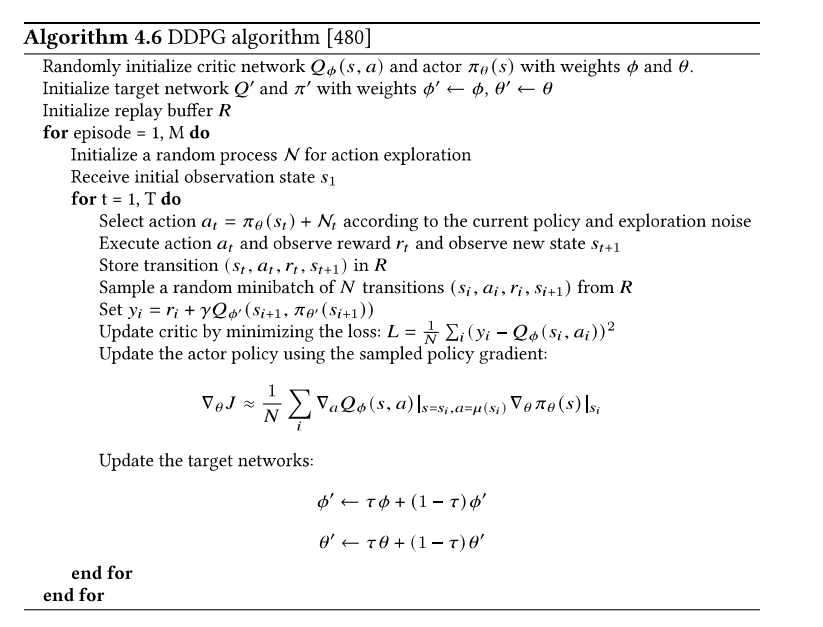

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import random
from collections import deque

c:\Users\raj\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ReplayBuffer:
    # initialization of Replay Buffer
    def __init__(self, buffer_limit, DEVICE):
        self.buffer = deque(maxlen=buffer_limit)
        self.dev = DEVICE

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_l, a_l, r_l, s_next_l, done_mask_l = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_next, done = transition
            s_l.append(s)
            a_l.append(a)
            r_l.append([r])
            s_next_l.append(s_next)
            done_mask = 0.0 if done else 1.0
            done_mask_l.append([done_mask])

        s_l = np.array(s_l, dtype=np.float32)
        a_l = np.array(a_l, dtype=np.float32)
        r_l = np.array(r_l, dtype=np.float32)
        s_next_l = np.array(s_next_l, dtype=np.float32)
        done_mask_l = np.array(done_mask_l, dtype=np.float32)

        s_batch = torch.tensor(s_l, dtype=torch.float).to(self.dev)
        a_batch = torch.tensor(a_l, dtype=torch.float).to(self.dev)
        r_batch = torch.tensor(r_l, dtype=torch.float).to(self.dev)
        s_prime_batch = torch.tensor(s_next_l, dtype=torch.float).to(self.dev)
        done_batch = torch.tensor(done_mask_l, dtype=torch.float).to(self.dev)

        return s_batch, a_batch, r_batch, s_prime_batch, done_batch
    
    def put(self, transition):
        self.buffer.append(transition)
        
    def size(self):
        return len(self.buffer)

Actor Network

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, actor_lr):
        super(Actor, self).__init__()

        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 64)
        self.fc_3 = nn.Linear(64, action_dim)
        self.max_action = 2

        self.optimizer = optim.Adam(self.parameters(), lr=actor_lr)

    def forward(self, x):
        x = F.leaky_relu(self.fc_1(x))
        x = F.leaky_relu(self.fc_2(x))
        x = torch.tanh(self.fc_3(x)) * self.max_action
        return x

Critic Network

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, critic_lr):
        super(Critic, self).__init__()

        self.fc_1 = nn.Linear(state_dim + action_dim, 64)
        self.fc_2 = nn.Linear(64, 64)
        self.fc_3 = nn.Linear(64, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=critic_lr)

    def forward(self, x, a):
        x = F.leaky_relu(self.fc_1(torch.cat([x, a], 1)))
        x = F.leaky_relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

Deep Deterministic Policy Gradient Agent

In [3]:
class DDPG_Agent:
    def __init__(self):
        self.state_dim = 3
        self.action_dim = 1
        self.actor_lr = 0.001
        self.critic_lr = 0.001
        self.gamma = 0.98
        self.tau = 0.005
        self.batch_size = 64
        self.buffer_limit = 100000
        
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = ReplayBuffer(self.buffer_limit, self.DEVICE)
        
        self.actor = Actor(self.state_dim, self.action_dim, self.actor_lr).to(
            self.DEVICE
        )
        self.actor_target = Actor(self.state_dim, self.action_dim, self.actor_lr).to(
            self.DEVICE
        )
        self.actor_target.load_state_dict(self.actor.state_dict())
        

        self.critic = Critic(self.state_dim, self.action_dim, self.critic_lr).to(
            self.DEVICE
        )
        self.critic_target = Critic(self.state_dim, self.action_dim, self.critic_lr).to(
            self.DEVICE
        )
        self.critic_target.load_state_dict(self.critic.state_dict())


    def train_agent(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        mini_batch = self.memory.sample(self.batch_size)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch

        target_Q = r_batch + self.gamma * self.critic_target(s_prime_batch, self.actor_target(s_prime_batch)).detach() * done_batch

        Q_loss = F.smooth_l1_loss(self.critic(s_batch, a_batch), target_Q)

        self.critic.optimizer.zero_grad()
        Q_loss.backward()
        self.critic.optimizer.step()

        policy_loss = -self.critic(s_batch, self.actor(s_batch)).mean()

        self.actor.optimizer.zero_grad()
        policy_loss.backward()
        self.actor.optimizer.step()

        for target_param, param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )

        for target_param, param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )
            
    def choose_action(self, state):
        with torch.no_grad():
            action = self.actor(state.to(self.DEVICE))
        return action

Ornstein Uhlenbeck Noise

In [6]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

Function to simulate pendulum environment such that the chosen action results in minimization of cost function.

In [7]:
def simulate_pendulum(state, action, mass, length, damping):
    dt = 0.05
    gravity = 9.81

    cos_theta, sin_theta, theta_dot = state
    torque = action[0]

    theta = np.arctan2(sin_theta, cos_theta)
    inertia = mass * length**2
    alpha = (torque - gravity * np.sin(theta) * length - damping * theta_dot) / inertia

    next_theta = theta + theta_dot * dt
    next_theta_dot = theta_dot + alpha * dt

    next_cos_theta = np.cos(next_theta)
    next_sin_theta = np.sin(next_theta)

    return np.array([next_cos_theta, next_sin_theta, next_theta_dot])

In [8]:
if __name__ == "__main__":
    agent = DDPG_Agent()
    ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(1))

    EPISODES = 500
    print_once = True
    score_list = []
    for EP in range(EPISODES):
        state = np.array([1.0, 0.0, 0.0])
        score, done = 0.0, False

        mass = 1.5
        length = 0.8
        b = 0.2    

        while not done:
            action = agent.choose_action(torch.FloatTensor(state))
            action = action.detach().cpu().numpy()  # GPU tensor to numpy array
            
            # Add noise to the action
            action = action + ou_noise()[0]  
            
            next_state = simulate_pendulum(state, action, mass, length, b)
            
            angle_deviation = np.arccos(next_state[0]) - np.pi
            
            reward = -(angle_deviation**2) - 0.1 * next_state[2] ** 2
            
            if np.abs(angle_deviation) < 0.1 and np.abs(next_state[2]) < 0.1:
                done = True
                reward += 100
                
            agent.memory.put((state, action, reward/100.0, next_state, done))
            
            score += reward
            state = next_state
            
            if agent.memory.size() > 1000:
                if print_once:
                    print("Training started!")
                print_once = False
                agent.train_agent()

        print("EP:{}, Avg_Score:{:.1f}".format(EP, score))
        score_list.append(score)


        with open("pendulum_scores_ddpg.txt", "w") as f:
            for score in score_list:
                f.write(str(score) + "\n")

        torch.save(agent.actor.state_dict(), "pendulum_actor_ddpg.pth")
        torch.save(agent.critic.state_dict(), "pendulum_critic_ddpg.pth")

Training started!
EP:0, Avg_Score:-65116.3
EP:1, Avg_Score:-3464.2
EP:2, Avg_Score:-2239.9
EP:3, Avg_Score:-2437.6
EP:4, Avg_Score:-733.4
EP:5, Avg_Score:-780.9
EP:6, Avg_Score:-944.7
EP:7, Avg_Score:-1315.3
EP:8, Avg_Score:-1091.5
EP:9, Avg_Score:-595.9
EP:10, Avg_Score:-580.6
EP:11, Avg_Score:-577.9
EP:12, Avg_Score:-570.8
EP:13, Avg_Score:-581.4
EP:14, Avg_Score:-575.6
EP:15, Avg_Score:-569.7
EP:16, Avg_Score:-567.7
EP:17, Avg_Score:-553.1
EP:18, Avg_Score:-551.9
EP:19, Avg_Score:-540.9
EP:20, Avg_Score:-540.9
EP:21, Avg_Score:-538.2
EP:22, Avg_Score:-541.0
EP:23, Avg_Score:-534.9
EP:24, Avg_Score:-533.2
EP:25, Avg_Score:-531.1
EP:26, Avg_Score:-665.9
EP:27, Avg_Score:-532.7
EP:28, Avg_Score:-529.1
EP:29, Avg_Score:-520.6
EP:30, Avg_Score:-522.3
EP:31, Avg_Score:-521.1
EP:32, Avg_Score:-521.3
EP:33, Avg_Score:-513.1
EP:34, Avg_Score:-513.0
EP:35, Avg_Score:-511.4
EP:36, Avg_Score:-512.1
EP:37, Avg_Score:-513.8
EP:38, Avg_Score:-510.2
EP:39, Avg_Score:-509.6
EP:40, Avg_Score:-514.2
E

Average Reward vs Episode plot

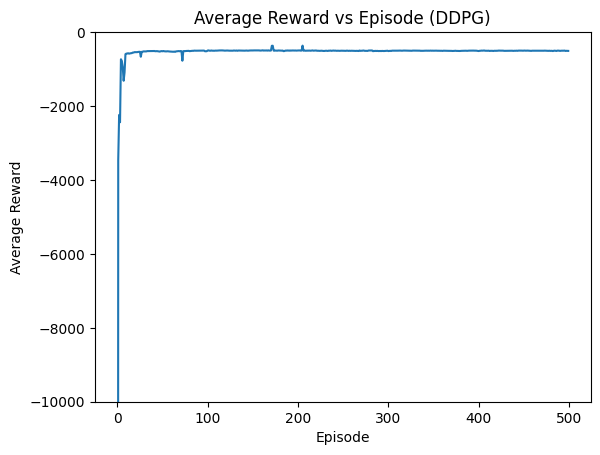

In [14]:
import matplotlib.pyplot as plt

plt.plot(score_list)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Episode (DDPG)")
plt.ylim([-10_000,1])
plt.show()

Network Architecture

In [10]:
agent = DDPG_Agent()
agent.actor.load_state_dict(torch.load('pendulum_actor_ddpg.pth', map_location=torch.device('cpu')))
agent.actor.eval()

Actor(
  (fc_1): Linear(in_features=3, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
agent.critic.load_state_dict(torch.load('pendulum_critic_ddpg.pth', map_location=torch.device('cpu')))
agent.critic.eval()

Critic(
  (fc_1): Linear(in_features=4, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=1, bias=True)
)

To plot the Optimal Input Trajectory Path and State Trajectories

In [12]:
state_dim = 3
action_dim = 1
mass = 1.5
length = 0.8
damping = 0.2
initial_state = np.array([1.0, 0.0, 0.0]) 

# Define time steps
num_steps = 150
dt = 0.001

# Initialize arrays to store state trajectories
cos_theta_traj = []
sin_theta_traj = []
theta_dot_traj = []
action_traj = []

# Simulate pendulum dynamics and store state trajectories
state = initial_state
for _ in range(num_steps):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    action = agent.choose_action(state_tensor).item()
    action_traj.append(action)

    next_state = simulate_pendulum(state, np.array([action]), mass, length, damping)
    cos_theta_traj.append(next_state[0])
    sin_theta_traj.append(next_state[1])
    theta_dot_traj.append(next_state[2])

    state = next_state

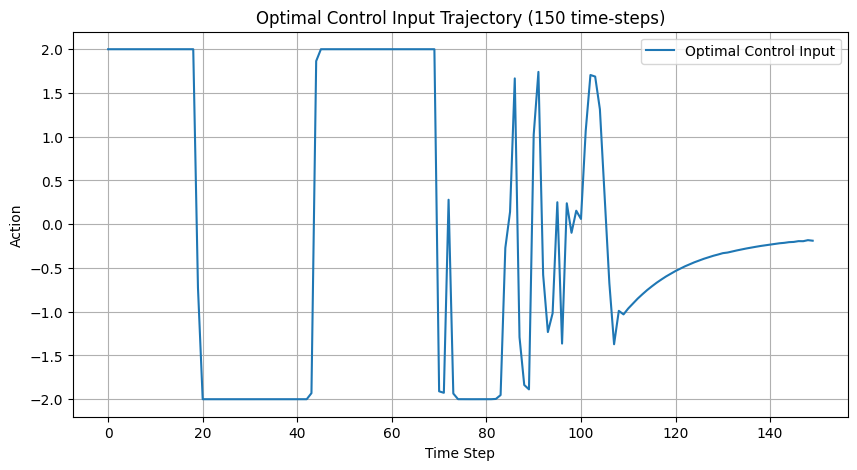

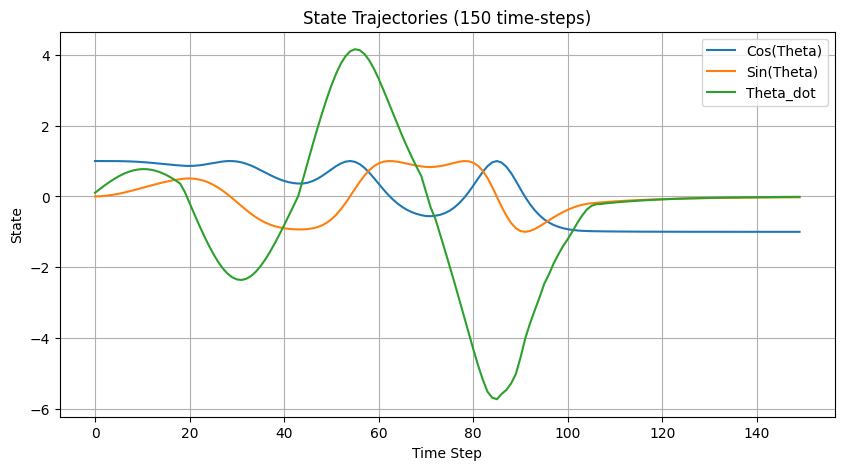

In [13]:
# Plot optimal control input trajectory
plt.figure(figsize=(10, 5))
plt.plot(action_traj, label='Optimal Control Input')
plt.xlabel('Time Step')
plt.ylabel('Action')
plt.title('Optimal Control Input Trajectory ('+str(num_steps)+' time-steps)')
plt.legend()
plt.grid(True)
plt.show()

# Plot state trajectories
plt.figure(figsize=(10, 5))
plt.plot(cos_theta_traj, label='Cos(Theta)')
plt.plot(sin_theta_traj, label='Sin(Theta)')
plt.plot(theta_dot_traj, label='Theta_dot')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.title('State Trajectories ('+str(num_steps)+' time-steps)')
plt.legend()
plt.grid(True)
plt.show()

Reference: https://github.com/seungeunrho/minimalRL